In [27]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import AlgoLoop
import StatisticFunc

plt.style.use('Solarize_Light2')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 预处理（剔除原油，铜，铁矿石）

## 提取并处理数据

### 权益类资产换手率

In [28]:
Turnovers = pd.read_excel(io="Raw/资产换手率.xlsx")                      # 读取数据
Turnovers = Turnovers.drop([0], axis=0)                                   # 删除多余行
Turnovers["日期"] = pd.DatetimeIndex(Turnovers["日期"])                    # 类型转换
Turnovers = Turnovers.set_index("日期")                                   # 设置索引

In [29]:
Turnovers = Turnovers[1:-1]

### GC007利率

In [30]:
Rates = pd.read_excel(io="Raw/GC007利率.xlsx")           #  读取数据
Rates = Rates.drop([0, 1, 2], axis=0)                   # 删除多余行
Rates.columns = ['日期', 'GC007']                        # 修改列名
Rates["日期"] = pd.DatetimeIndex(Rates["日期"])           # 类型转换
Rates = Rates.set_index("日期")                          # 设置索引

In [31]:
Rates = Rates[1:-1]                    

### 十年国债收益率

In [32]:
BondRates = pd.read_excel(io="Raw/中债国债到期收益率(中债)(日).xls")        # 读取数据
BondRates.columns = ['日期', '十年国债收益率']                             # 修改列名
BondRates = BondRates.drop([0, 3870, 3871], axis=0)                     # 删除多余行
BondRates["日期"] = pd.DatetimeIndex(BondRates["日期"])                   # 类型转换
BondRates = BondRates.set_index("日期")                                  # 设置索引

### 各资产收盘价

In [33]:
Assets = pd.read_excel(io="Raw/资产收盘价.xlsx")
Assets = Assets.drop([0], axis=0)                                   # 删除多余行
Assets["日期"] = pd.DatetimeIndex(Assets["日期"])                    # 类型转换
Assets = Assets.set_index("日期")                                   # 设置索引

### 十年国债价格指数

In [34]:
Data = Assets.merge(BondRates, how='left', left_index=True, right_index=True)

In [35]:
Data = Data.merge(Rates, how='left', left_index=True, right_index=True)

In [36]:
Data['持有时长'] = (Data.index - Data.index[0]).days
Data['10年国债价格指数'] = 100 - (Data['十年国债收益率'] - 3.0) * 8.2 + 3.0 * Data['持有时长'] / 365.0
Data['10年国债价格指数'] = Data['10年国债价格指数'].fillna(method='ffill')

In [37]:
# 利用自制10年国债价格指数，替换上证10年国债
Assets['中国10年国债'] = Data['10年国债价格指数'].values
Assets = Assets.drop('上证10年国债', axis=1)

## 计算各资产收益率

In [38]:
# 去掉没有10年国债数据的日期
Assets = Assets[:-10]

### 日内损益

In [39]:
Returns = Assets.pct_change(axis=0)
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

In [40]:
drop_lst = ['中信证券COMEX铜期货', '中信证券WTI原油期货', '中信证券铁矿石', '标普500']
Returns = Returns.drop(drop_lst, axis=1)

In [41]:
Returns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,中国10年国债
日期,,,,,
2020-06-18,0.006668,-0.000177,0.000089,-0.002171,0.001689
2020-06-19,0.013432,0.009198,-0.000031,0.012794,-0.001272
2020-06-22,0.000814,-0.000539,-0.001018,0.006962,-0.002197
2020-06-23,0.004814,0.003512,-0.001891,0.006070,0.000214
2020-06-24,0.004172,-0.002628,-0.000168,-0.005507,0.003104


### 累计损益

In [42]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

In [43]:
cumReturns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,中国10年国债
日期,,,,,
2020-06-18,0.751032,1.119141,2.012302,1.640893,1.571182
2020-06-19,0.761120,1.129435,2.012240,1.661886,1.569184
2020-06-22,0.761740,1.128825,2.010192,1.673456,1.565736
2020-06-23,0.765407,1.132790,2.006390,1.683614,1.566071
2020-06-24,0.768600,1.129813,2.006052,1.674342,1.570932


### 杠杆调整后的债券净值

In [46]:
lever = 2.0                                 # 杠杆
leverReturns = Returns.copy()               # 创建副本 
leverCumReturns = cumReturns.copy()   

# 更新杠杆调整后的债券净值
leverReturns.loc[:, ['中国10年国债', '信用债3-5AAA']] = Returns.loc[:, ['中国10年国债', '信用债3-5AAA']] * (1.0 + lever) - Rates.values * lever / (365.0 * 100)

# 更新累计净值
leverCumReturns = (1.0 + leverReturns)
leverCumReturns = leverCumReturns.fillna(1.0)                    # 填充空值
leverCumReturns = leverCumReturns.cumprod()                      # 计算各资产累计收益率

In [47]:
leverCumReturns.tail()

,沪深300,中证500,信用债3-5AAA,中信证券COMEX黄金期货,中国10年国债
日期,,,,,
2020-06-18,0.751032,1.119141,4.942358,1.640893,2.303008
2020-06-19,0.761120,1.129435,4.941123,1.661886,2.293859
2020-06-22,0.761740,1.128825,4.925184,1.673456,2.278346
2020-06-23,0.765407,1.132790,4.896426,1.683614,2.279431
2020-06-24,0.768600,1.129813,4.892953,1.674342,2.300194


# 风险平价 + 杠杆策略（指数权重EMA）

## 程序运行

In [48]:
tradeDF_base, weightDF_base = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema')

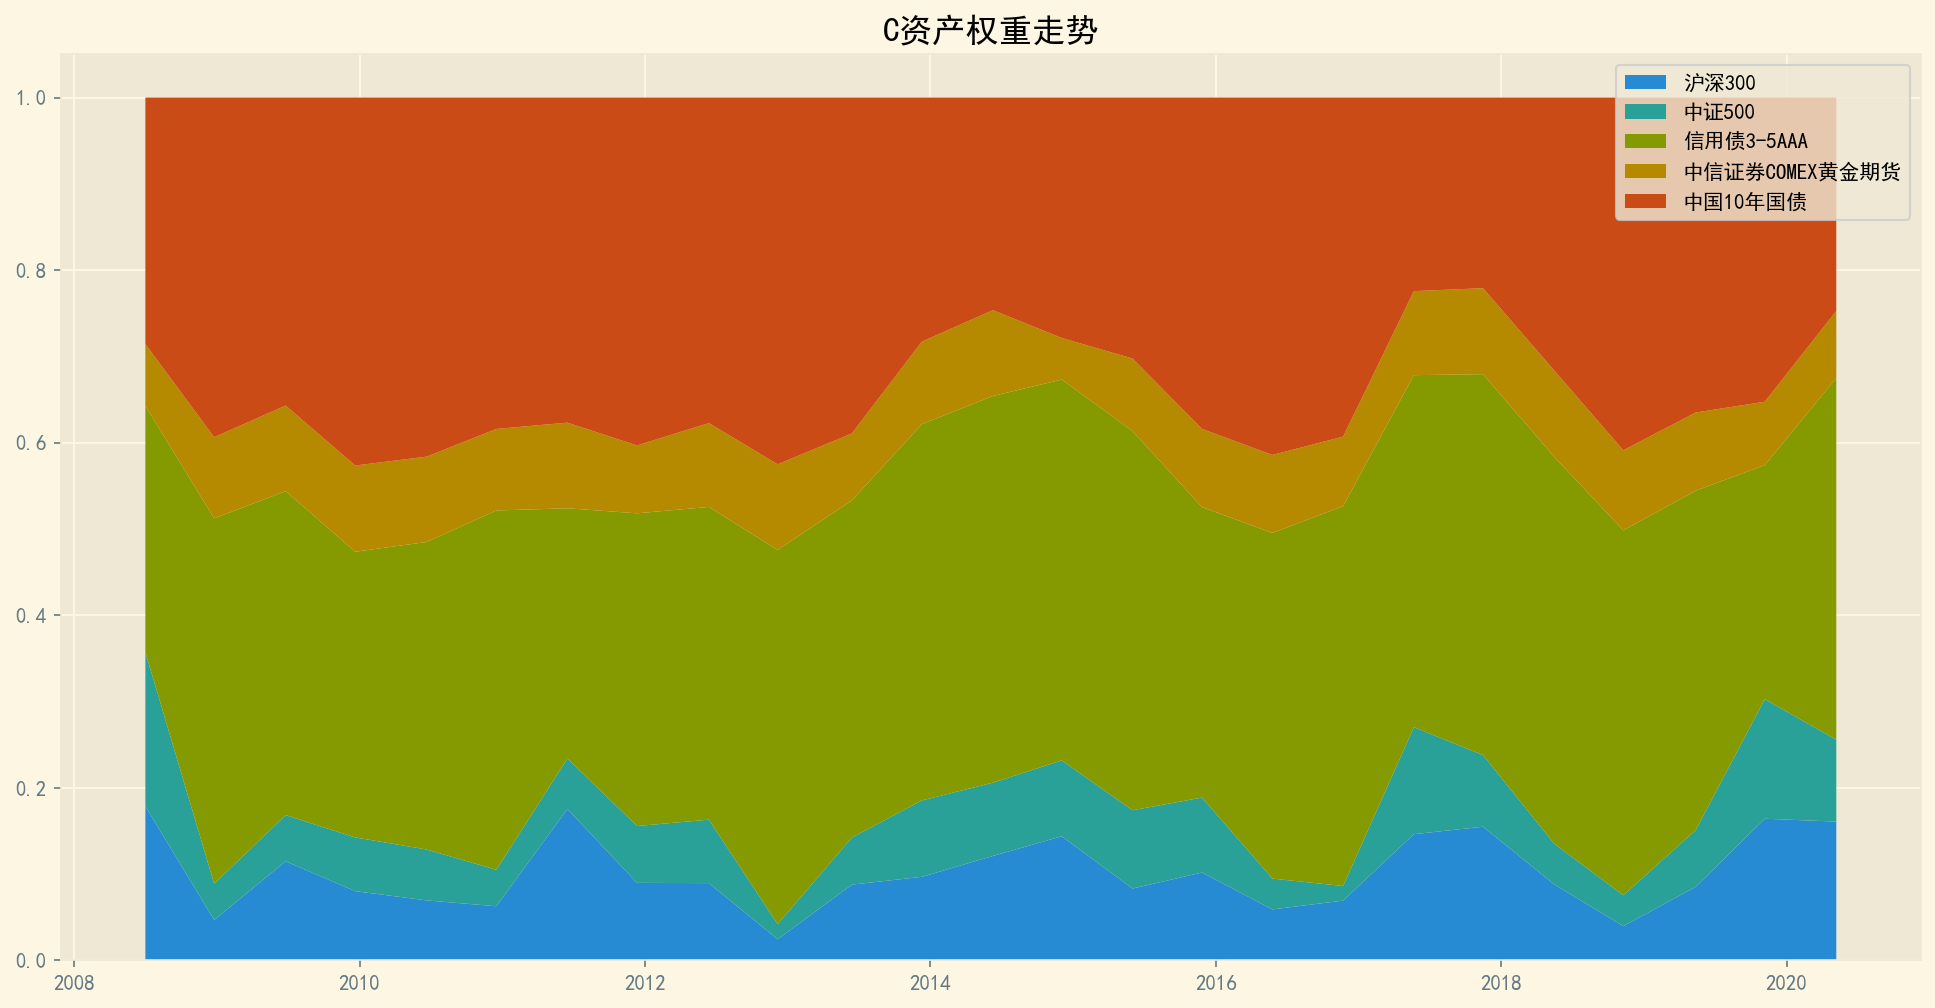

In [49]:
StatisticFunc.WeightPlot(tradeDF_base, weightDF_base, 'C')

## 回测表现汇总

In [50]:
# 表现汇总
years = np.unique(tradeDF_base.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_base = pd.DataFrame(index=years)

SummaryDF_base["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_base['投资组合净值']) )
SummaryDF_base["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_base['投资组合净值'])).values
SummaryDF_base["无基准夏普比率"] = SummaryDF_base['年收益率'] / SummaryDF_base['年波动率']
SummaryDF_base["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_base['最大回撤'])).values

SummaryDF_base

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.137905,0.166786,0.826837,-0.102252
2009,0.0778676,0.088260,0.882248,-0.055240
2010,0.0654674,0.066005,0.99186,-0.074328
2011,0.0610043,0.076467,0.797784,-0.092203
2012,0.0397277,0.045690,0.869512,-0.051353
2013,-0.102087,0.063540,-1.60665,-0.150207
2014,0.309355,0.057486,5.38143,-0.154190
2015,0.297621,0.079875,3.72607,-0.056014
2016,-0.0150667,0.057667,-0.261269,-0.100811
2017,-0.0244385,0.040574,-0.602316,-0.126786


## 收益率贡献度

In [51]:
annualContrb_base = StatisticFunc.AnnualContribution(tradeDF=tradeDF_base, weightDF=weightDF_base, assetDF=leverCumReturns)

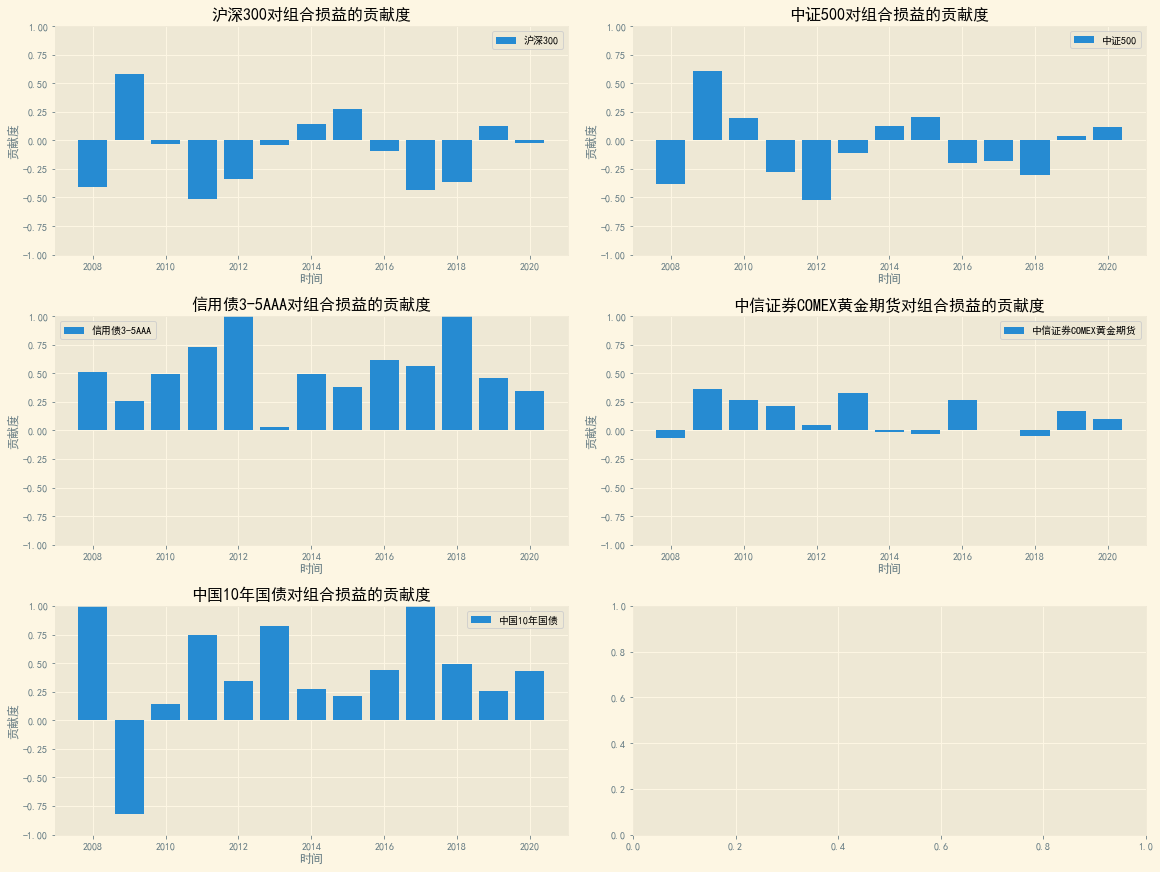

In [52]:
StatisticFunc.BarPlot(annualContrb_base, 'C')

## 投资组合净值曲线

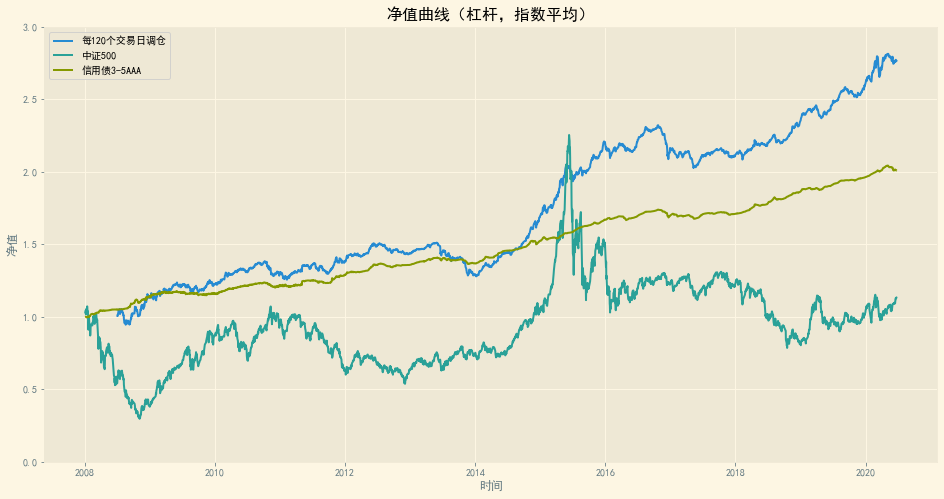

In [138]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_base.index, tradeDF_base['投资组合净值']/10000, label='每120个交易日调仓')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均）')
plt.savefig('净值曲线（杠杆，指数平均）C.png')

# 基准组合（多因子）

## 程序运行

In [60]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF, weightDF = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

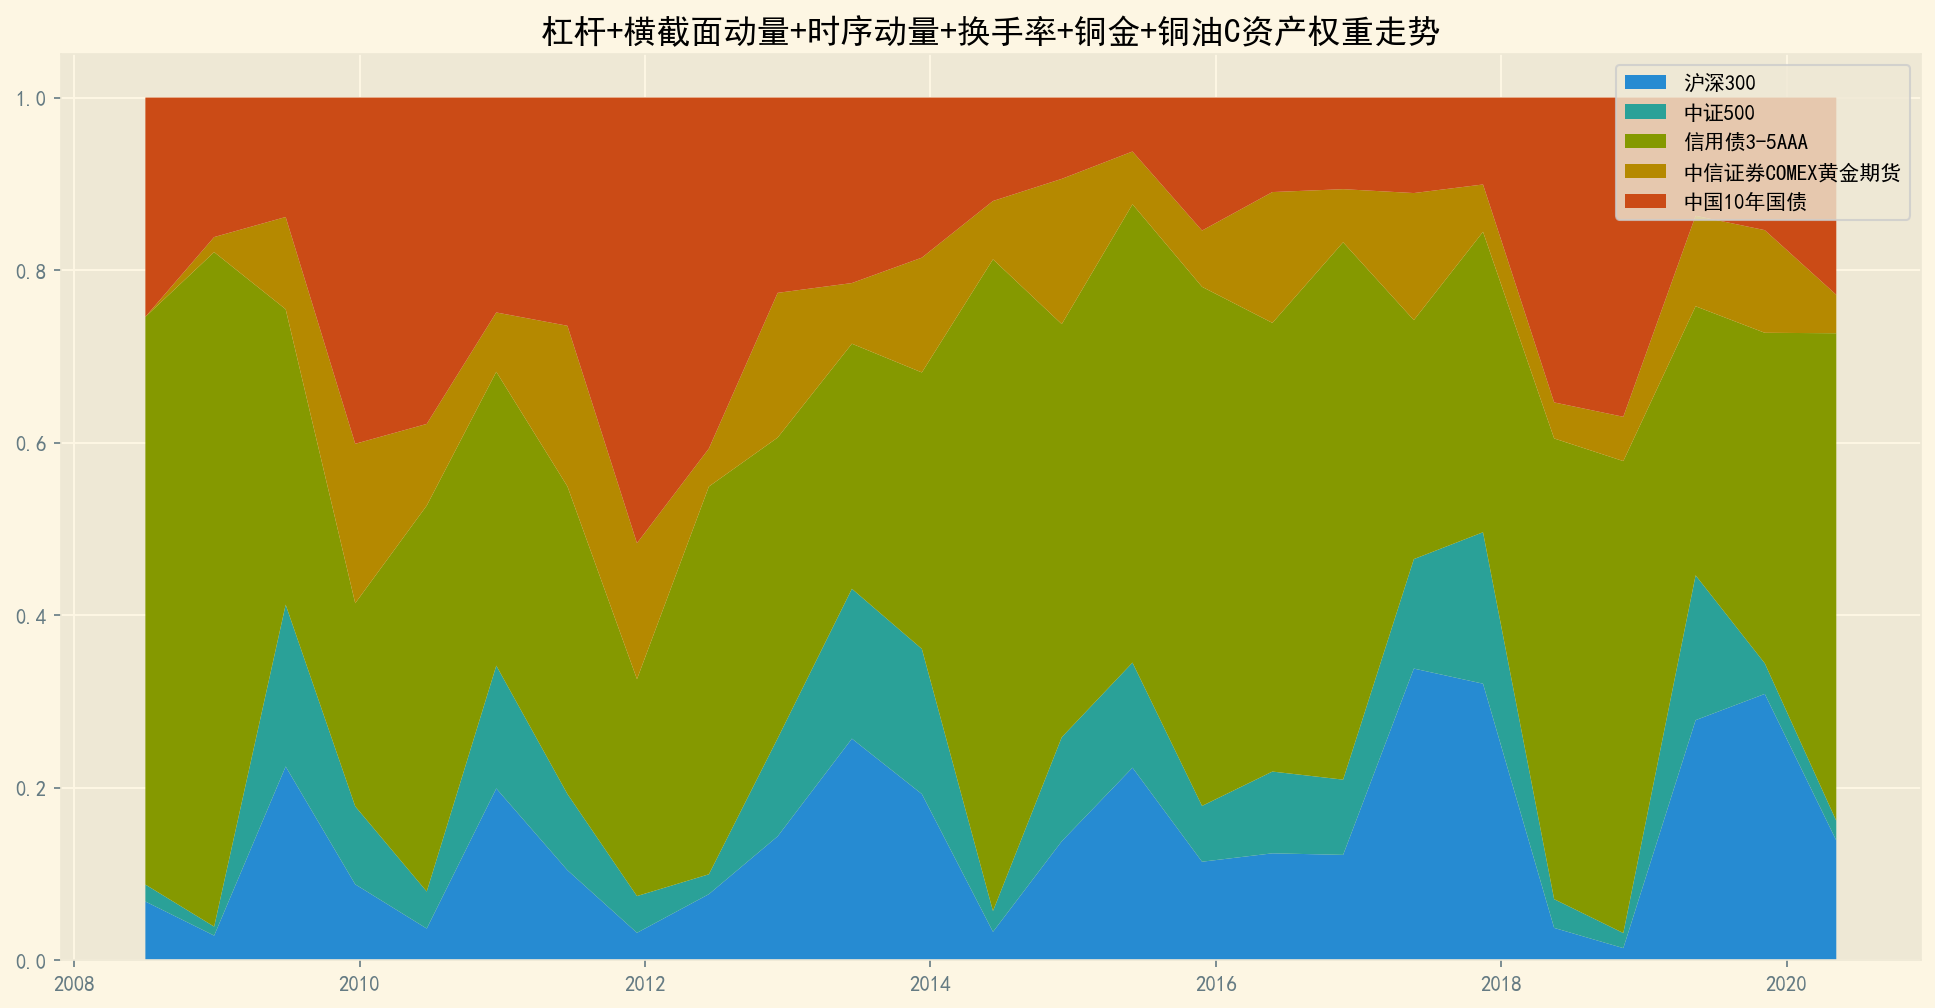

In [61]:
StatisticFunc.WeightPlot(tradeDF, weightDF, '杠杆+横截面动量+时序动量+换手率+铜金+铜油C')

## 回测表现汇总

In [62]:
# 表现汇总
years = np.unique(tradeDF.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF = pd.DataFrame(index=years)

SummaryDF["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF['投资组合净值']) )
SummaryDF["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF['投资组合净值'])).values
SummaryDF["无基准夏普比率"] = SummaryDF['年收益率'] / SummaryDF['年波动率']
SummaryDF["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF['最大回撤'])).values

SummaryDF

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.302383,0.132678,2.27907,-0.045878
2009,0.137279,0.137820,0.996075,-0.104318
2010,0.0369912,0.068422,0.540636,-0.091078
2011,0.0369328,0.084110,0.439103,-0.115487
2012,0.0608168,0.046610,1.3048,-0.051942
2013,-0.0738412,0.096623,-0.764224,-0.121061
2014,0.224407,0.059800,3.75263,-0.126798
2015,0.241971,0.114284,2.11727,-0.113110
2016,-0.00398852,0.054760,-0.0728364,-0.083639
2017,0.0238276,0.050344,0.4733,-0.107878


## 收益率贡献度

In [63]:
annualContrb = StatisticFunc.AnnualContribution(tradeDF=tradeDF, weightDF=weightDF, assetDF=leverCumReturns)

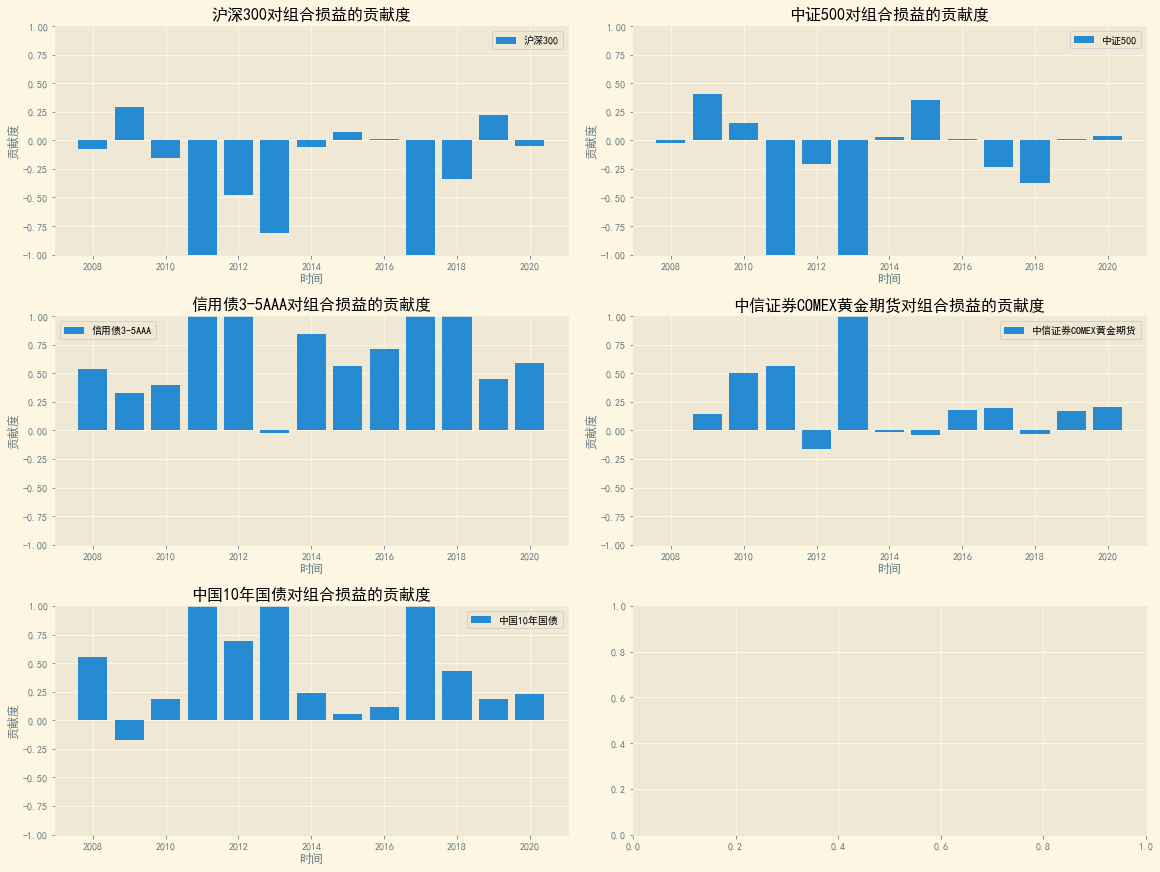

In [64]:
StatisticFunc.BarPlot(annualContrb, '横截面动量+时序动量+换手率+铜金+铜油C')

## 投资组合净值曲线

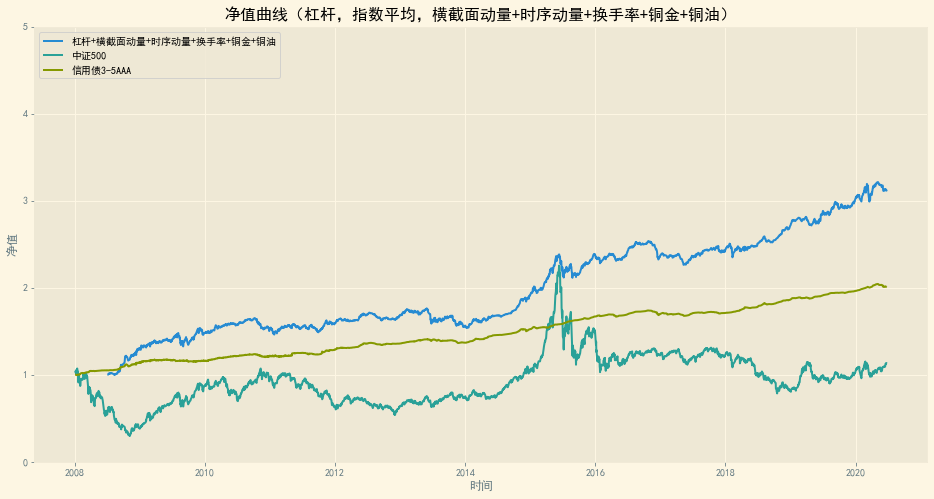

In [65]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, label='杠杆+横截面动量+时序动量+换手率+铜金+铜油')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金+铜油）C.png')

# 风险平价 + 杠杆 + 多因子策略（指数平均）

## 换手率+铜金+铜油

### 程序运行

In [96]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_1, weightDF_1 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

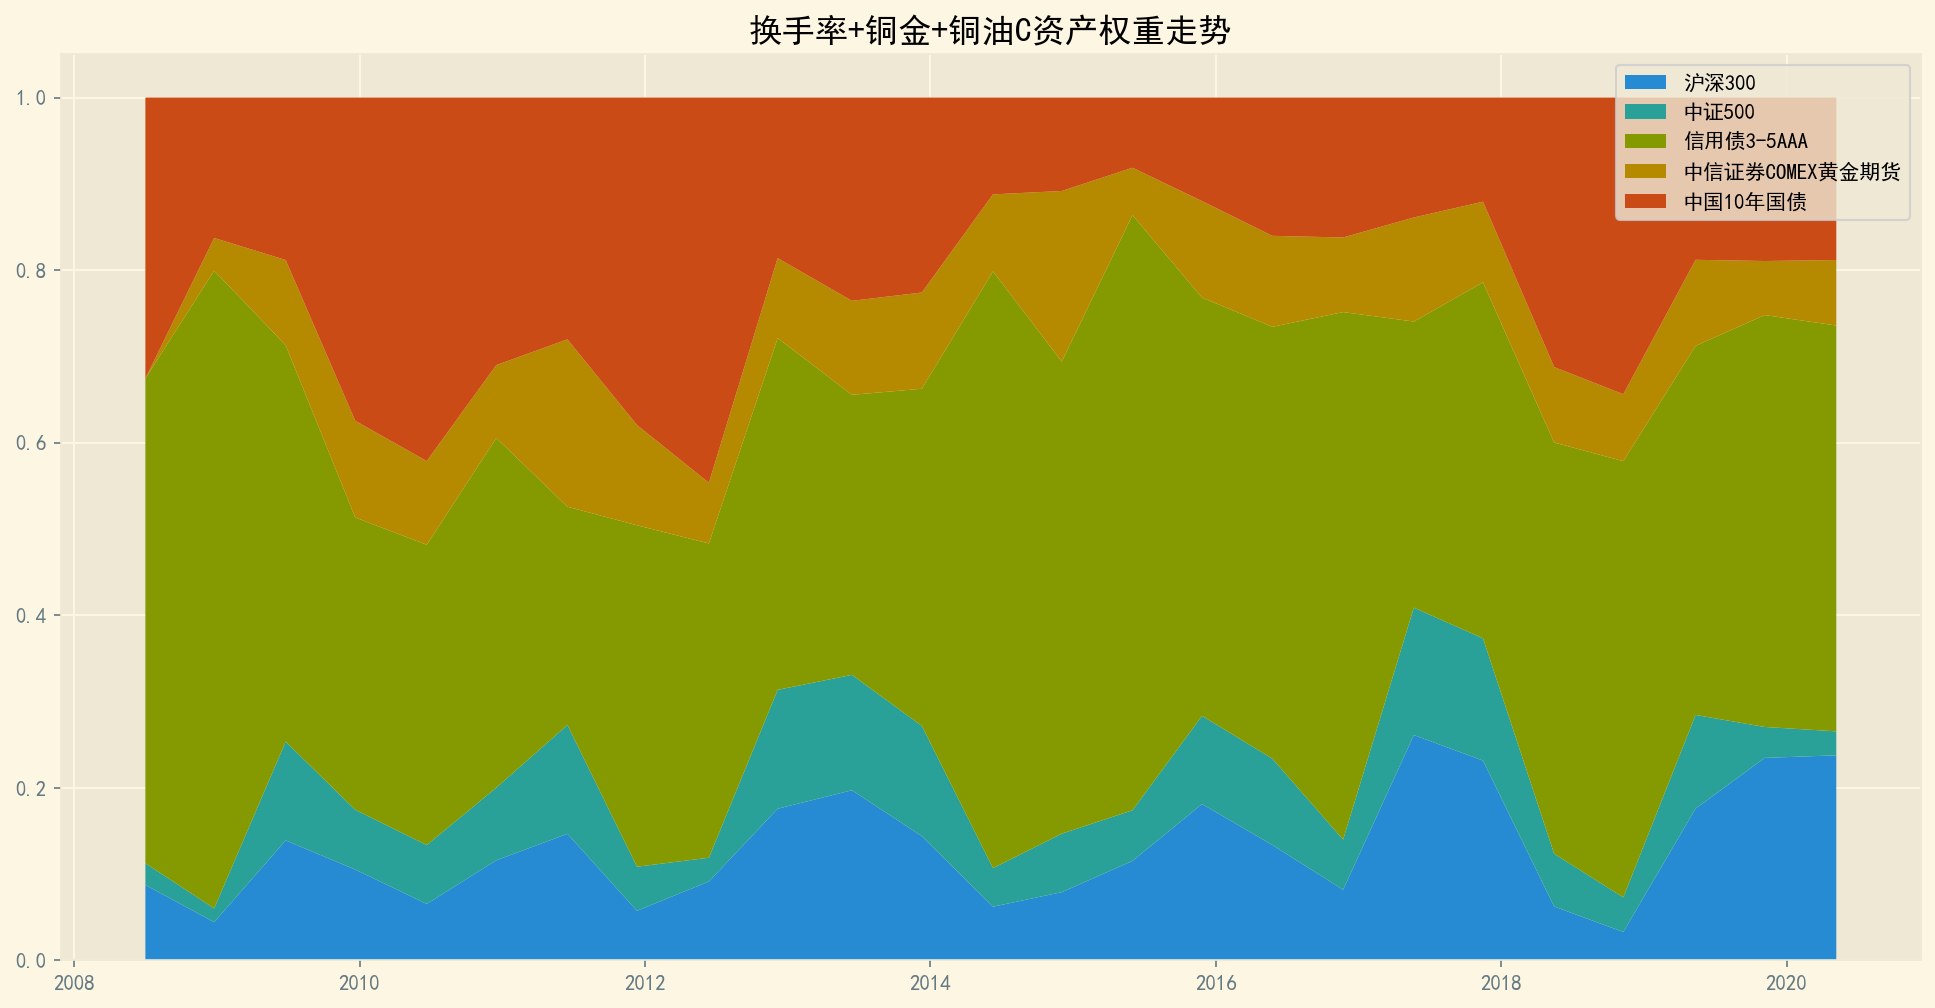

In [97]:
StatisticFunc.WeightPlot(tradeDF_1, weightDF_1, '换手率+铜金+铜油C')

### 回测表现汇总

In [98]:
# 表现汇总
years = np.unique(tradeDF_1.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_1 = pd.DataFrame(index=years)

SummaryDF_1["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_1['投资组合净值']) )
SummaryDF_1["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_1['投资组合净值'])).values
SummaryDF_1["无基准夏普比率"] = SummaryDF_1['年收益率'] / SummaryDF_1['年波动率']
SummaryDF_1["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_1['最大回撤'])).values

SummaryDF_1

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.31645,0.134015,2.36131,-0.042926
2009,0.11736,0.109402,1.07274,-0.065192
2010,0.0550513,0.067581,0.814602,-0.076442
2011,0.0382676,0.082792,0.462212,-0.096343
2012,0.0895838,0.047648,1.88011,-0.048281
2013,-0.0712498,0.089604,-0.795166,-0.135233
2014,0.242239,0.051516,4.70221,-0.139765
2015,0.249703,0.067576,3.69517,-0.048083
2016,-0.0160143,0.068565,-0.233565,-0.085565
2017,0.0113339,0.045028,0.251708,-0.109021


### 收益率贡献度

In [99]:
annualContrb_1 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_1, weightDF=weightDF_1, assetDF=leverCumReturns)

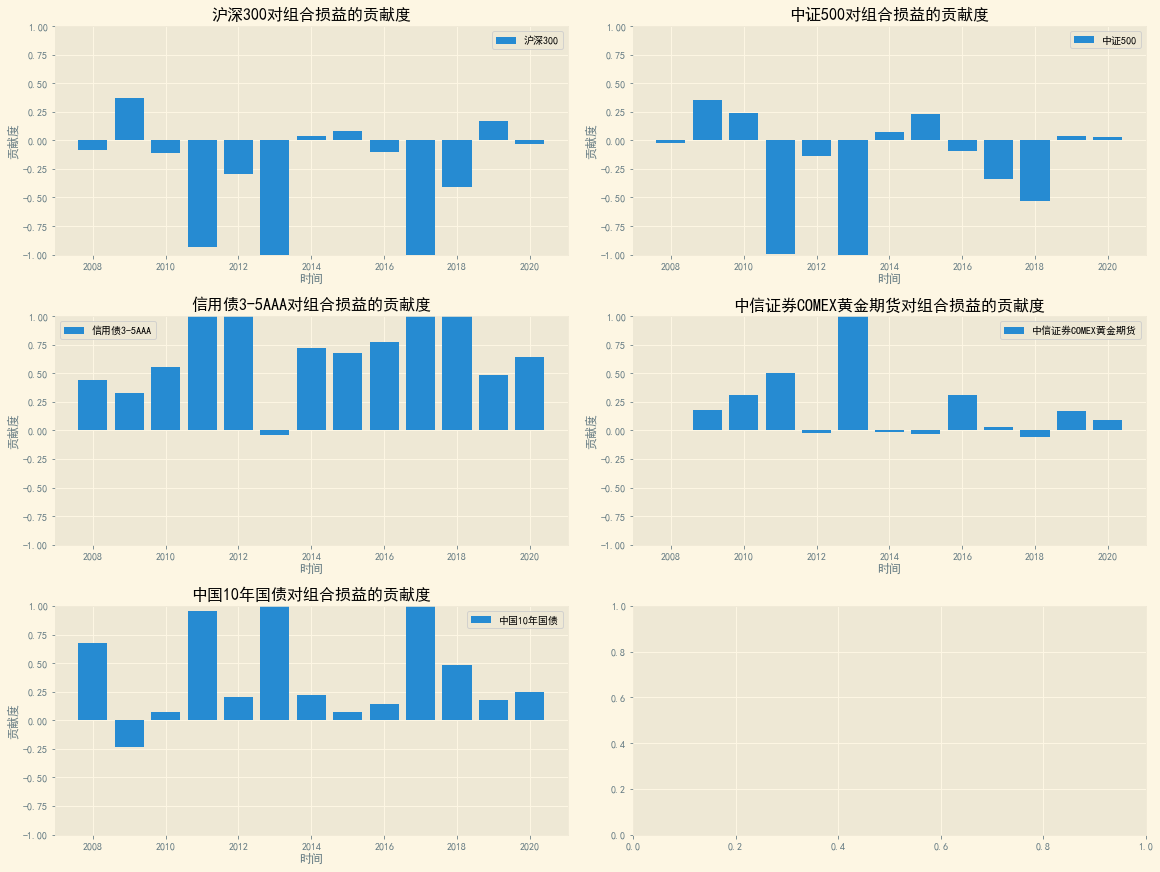

In [100]:
StatisticFunc.BarPlot(annualContrb_1, '时序动量+换手率+铜金+铜油C')

### 投资组合净值曲线

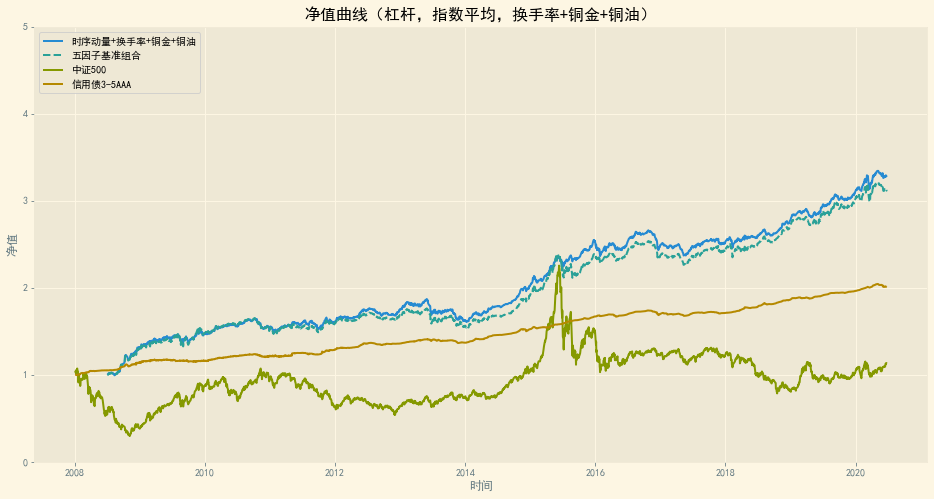

In [101]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='时序动量+换手率+铜金+铜油')

# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，换手率+铜金+铜油）C.png')

## 横截面动量+换手率+铜金+铜油

### 程序运行

In [102]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_2, weightDF_2 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

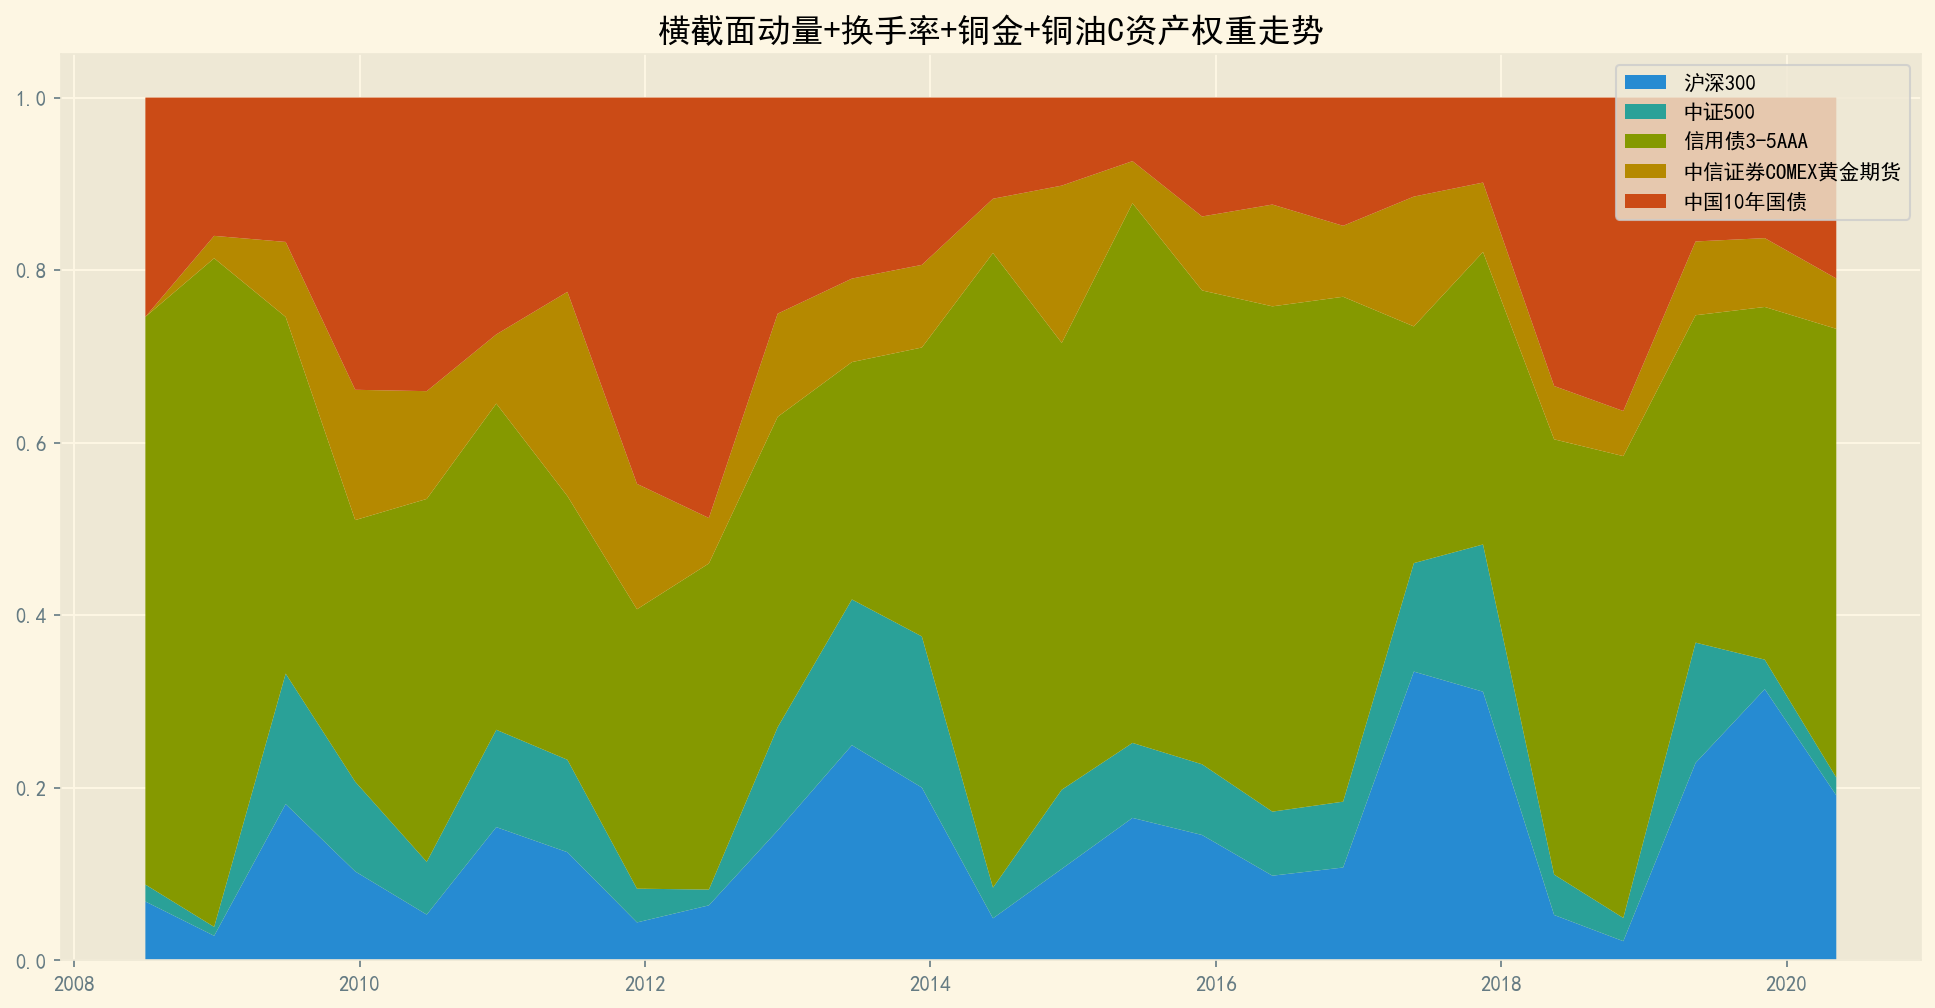

In [103]:
StatisticFunc.WeightPlot(tradeDF_2, weightDF_2, '横截面动量+换手率+铜金+铜油C')

### 回测表现汇总

In [104]:
# 表现汇总
years = np.unique(tradeDF_2.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_2 = pd.DataFrame(index=years)

SummaryDF_2["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_2['投资组合净值']) )
SummaryDF_2["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_2['投资组合净值'])).values
SummaryDF_2["无基准夏普比率"] = SummaryDF_2['年收益率'] / SummaryDF_2['年波动率']
SummaryDF_2["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_2['最大回撤'])).values

SummaryDF_2

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.302743,0.132697,2.28147,-0.045878
2009,0.118286,0.122880,0.962613,-0.084731
2010,0.048843,0.068686,0.711104,-0.078251
2011,0.0362157,0.085650,0.422833,-0.100497
2012,0.0768689,0.046472,1.6541,-0.051126
2013,-0.0643445,0.095444,-0.674161,-0.122023
2014,0.225839,0.058634,3.85168,-0.129497
2015,0.250091,0.087182,2.86861,-0.075070
2016,-0.0118437,0.058850,-0.201254,-0.086604
2017,0.0223253,0.049846,0.447883,-0.109468


### 收益率贡献度

In [105]:
annualContrb_2 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_2, weightDF=weightDF_2, assetDF=leverCumReturns)

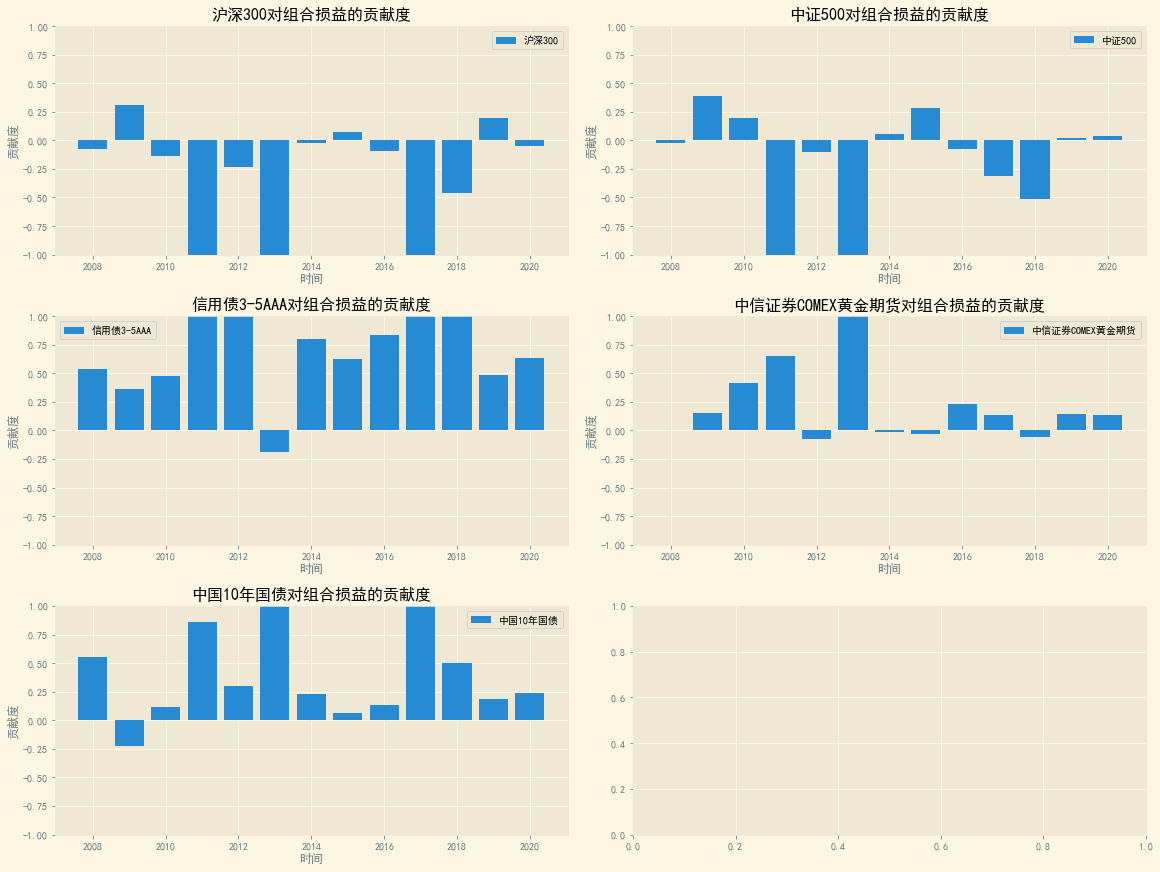

In [106]:
StatisticFunc.BarPlot(annualContrb_2, '横截面动量+换手率+铜金+铜油C')

### 投资组合净值曲线

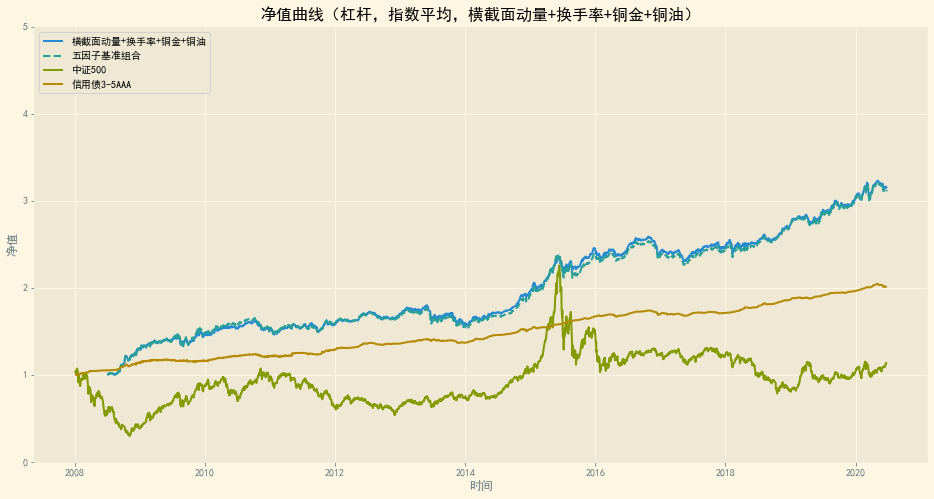

In [107]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量+换手率+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金+铜油）C.png')

## 横截面动量+铜油

### 程序运行

In [126]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':False, 'copperGas':True}

tradeDF_3, weightDF_3 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

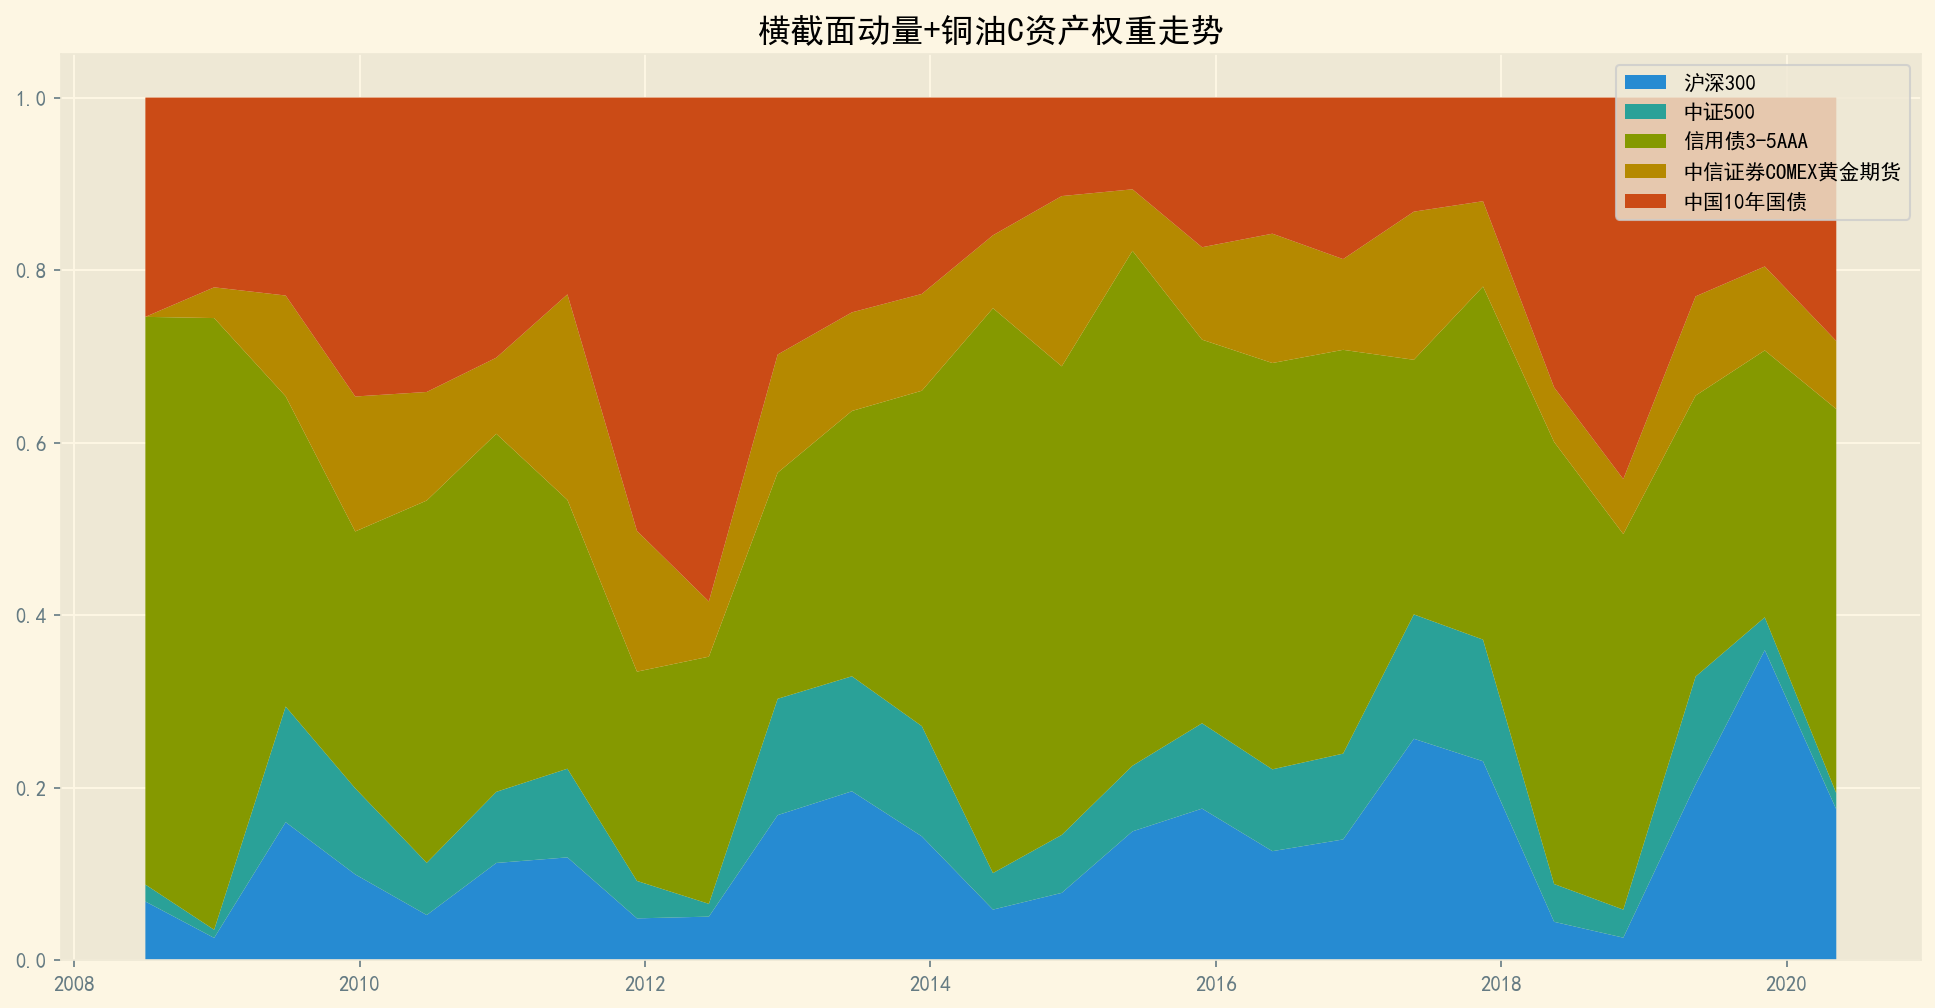

In [127]:
StatisticFunc.WeightPlot(tradeDF_3, weightDF_3, '横截面动量+铜油C')

### 回测表现汇总

In [128]:
# 表现汇总
years = np.unique(tradeDF_3.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_3 = pd.DataFrame(index=years)

SummaryDF_3["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_3['投资组合净值']) )
SummaryDF_3["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_3['投资组合净值'])).values
SummaryDF_3["无基准夏普比率"] = SummaryDF_3['年收益率'] / SummaryDF_3['年波动率']
SummaryDF_3["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_3['最大回撤'])).values

SummaryDF_3

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.301312,0.132365,2.27638,-0.045878
2009,0.10445,0.114000,0.916222,-0.075164
2010,0.0537295,0.067868,0.79168,-0.074385
2011,0.0450245,0.083798,0.537295,-0.094115
2012,0.0759912,0.049627,1.53123,-0.050088
2013,-0.0866806,0.090037,-0.96272,-0.136573
2014,0.241672,0.052358,4.61581,-0.141085
2015,0.221696,0.077069,2.87659,-0.064862
2016,-0.0169832,0.067382,-0.252044,-0.084992
2017,0.0145339,0.046925,0.309724,-0.105442


### 收益率贡献度

In [129]:
annualContrb_3 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_3, weightDF=weightDF_3, assetDF=leverCumReturns)

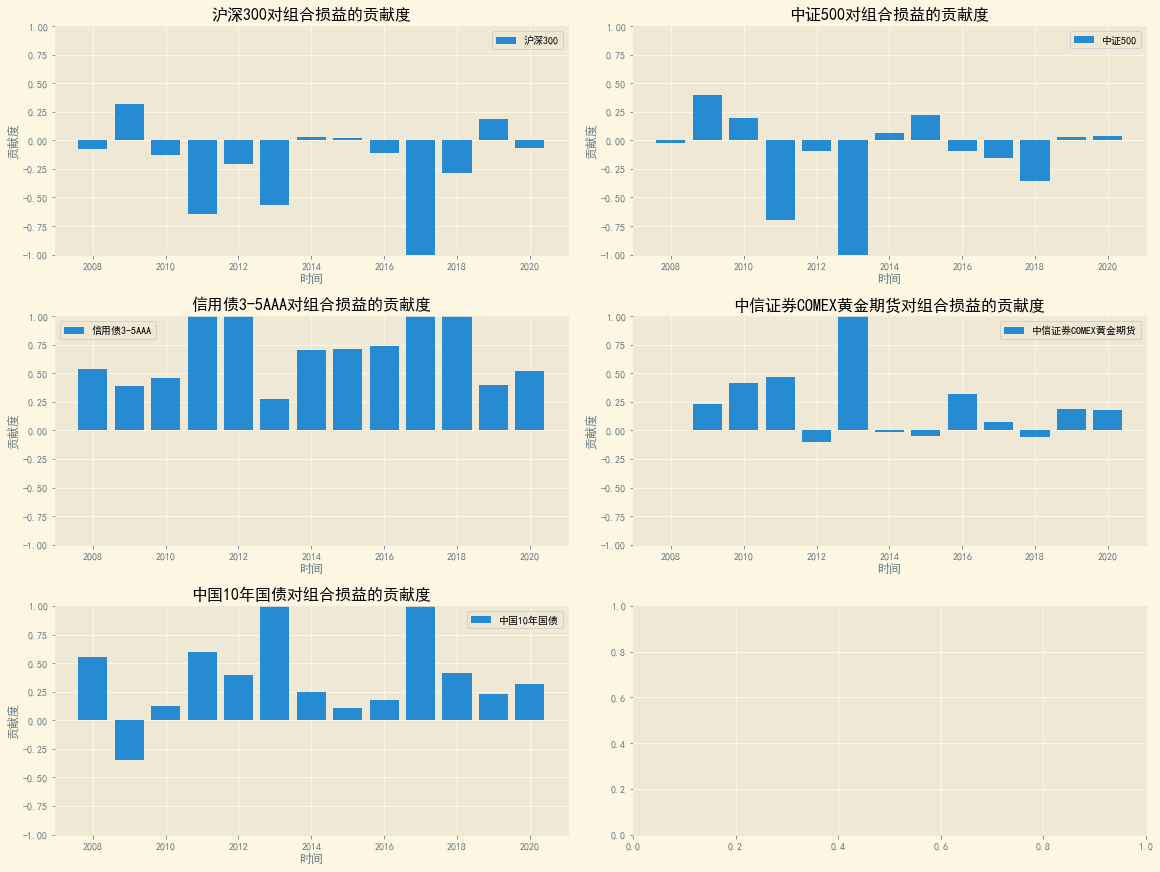

In [130]:
StatisticFunc.BarPlot(annualContrb_3, '横截面动量+铜油C')

### 投资组合净值曲线

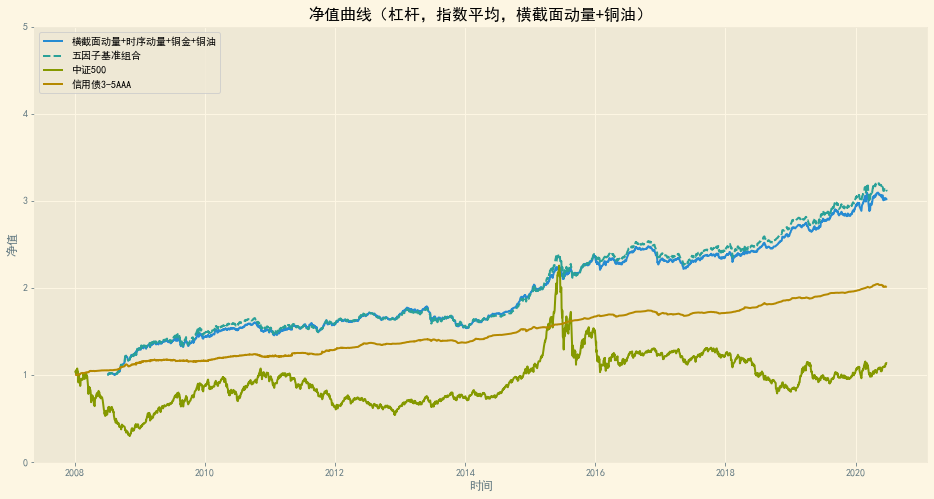

In [131]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='横截面动量+时序动量+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+铜油）C.png')

## 横截面动量+换手率

### 程序运行

In [132]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':False, 'copperGas':False}

tradeDF_4, weightDF_4 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

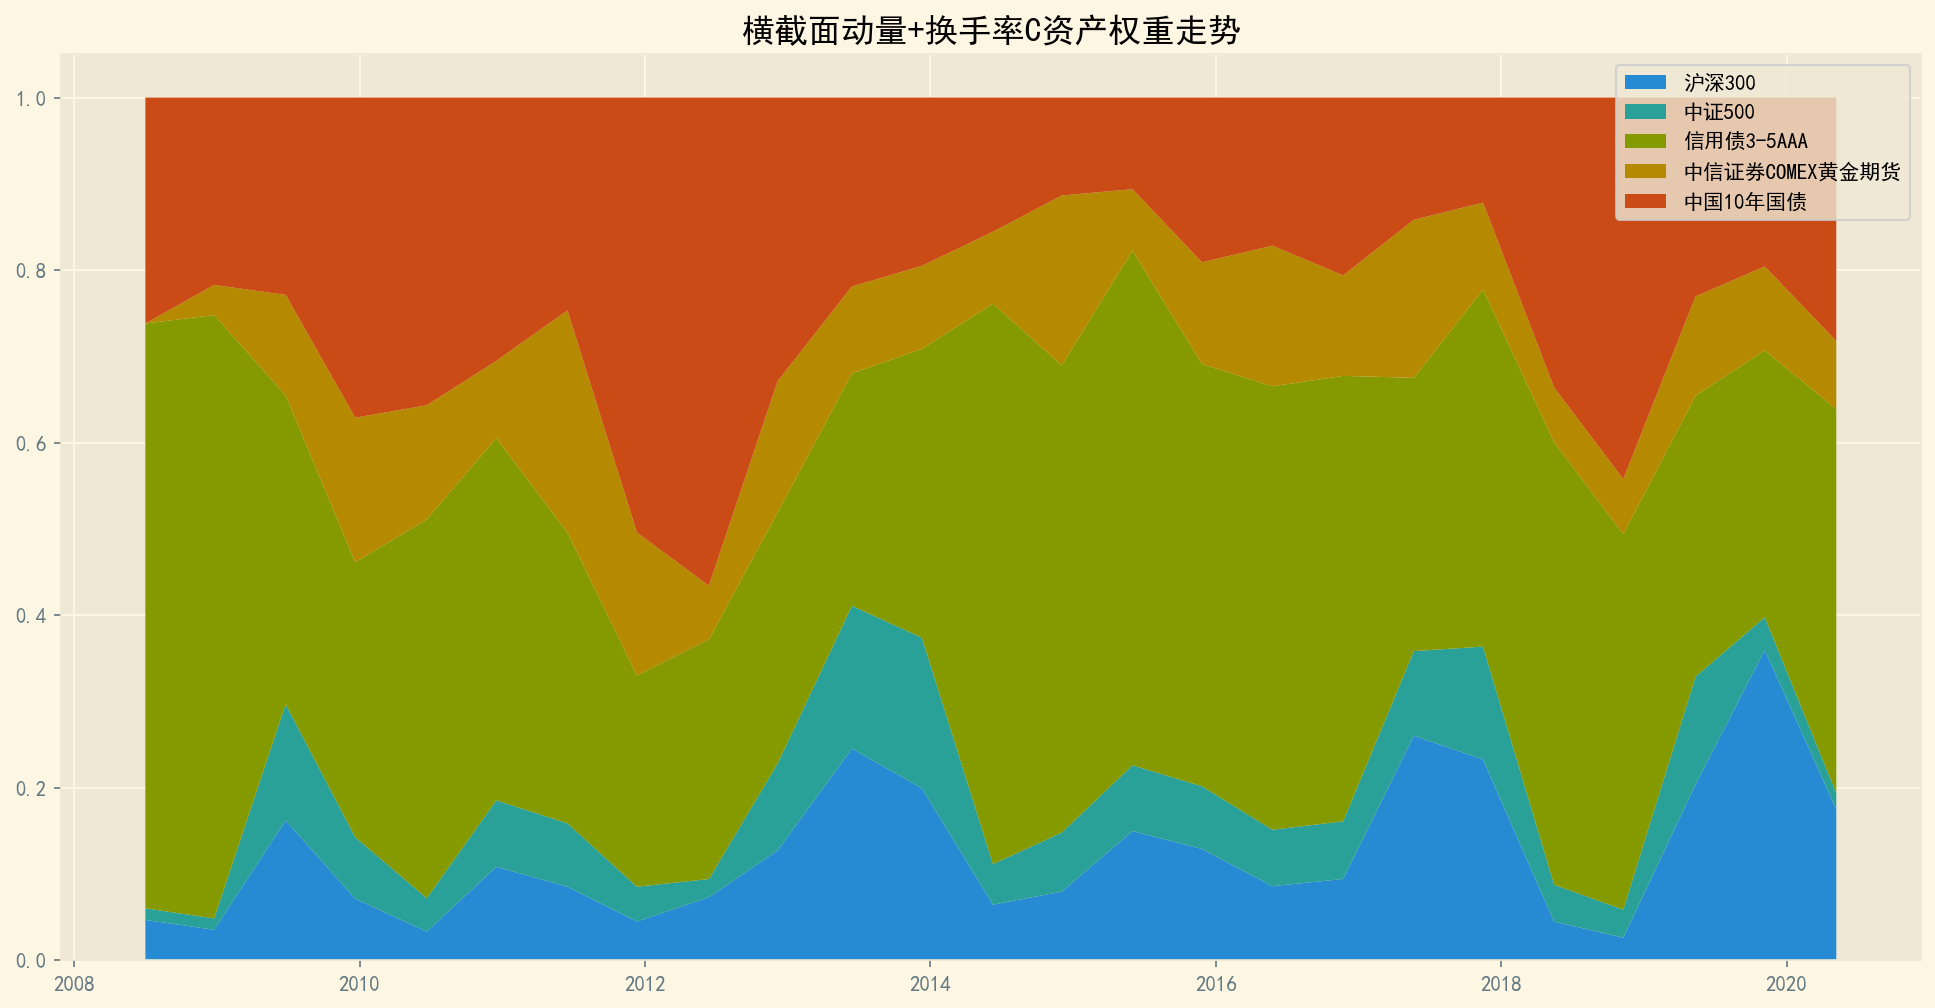

In [133]:
StatisticFunc.WeightPlot(tradeDF_4, weightDF_4, '横截面动量+换手率C')

### 回测表现汇总

In [134]:
# 表现汇总
years = np.unique(tradeDF_4.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_4 = pd.DataFrame(index=years)

SummaryDF_4["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_4['投资组合净值']) )
SummaryDF_4["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_4['投资组合净值'])).values
SummaryDF_4["无基准夏普比率"] = SummaryDF_4['年收益率'] / SummaryDF_4['年波动率']
SummaryDF_4["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_4['最大回撤'])).values

SummaryDF_4

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.318514,0.133918,2.37844,-0.044437
2009,0.110904,0.114053,0.97239,-0.075880
2010,0.0595389,0.064804,0.918759,-0.079933
2011,0.0618343,0.083221,0.743016,-0.099158
2012,0.0602458,0.047889,1.25804,-0.050463
2013,-0.0743584,0.092949,-0.799988,-0.120919
2014,0.223167,0.058162,3.83699,-0.128337
2015,0.222835,0.076678,2.90613,-0.065103
2016,-0.00481346,0.056940,-0.0845358,-0.089674
2017,0.00653115,0.043956,0.148585,-0.109991


### 收益率贡献度

In [135]:
annualContrb_4 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_4, weightDF=weightDF_4, assetDF=leverCumReturns)

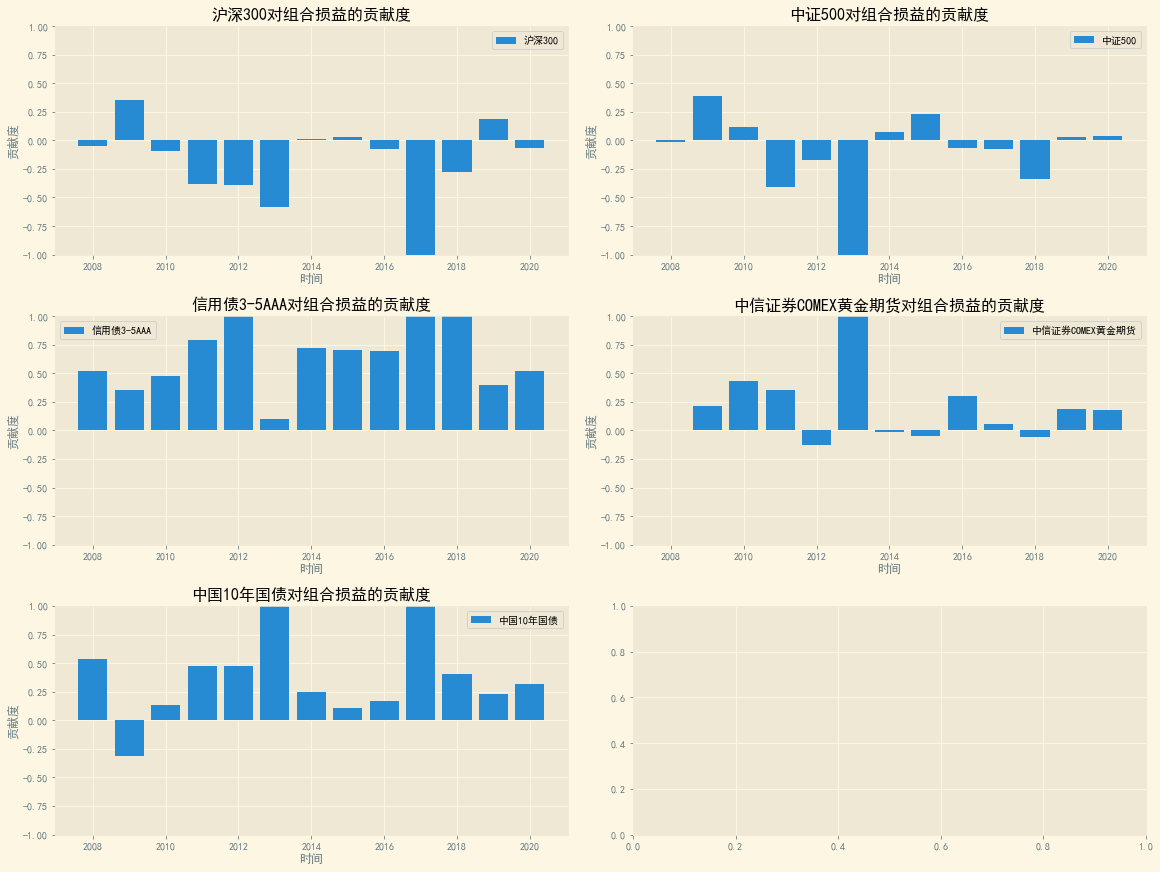

In [136]:
StatisticFunc.BarPlot(annualContrb_4, '横截面动量+换手率C')

### 投资组合净值曲线

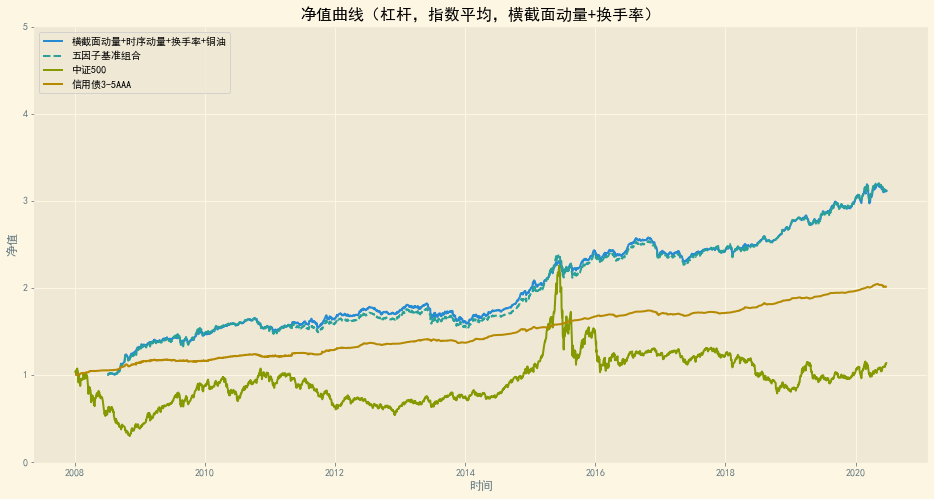

In [137]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_4.index, tradeDF_4['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+换手率）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+换手率）C.png')

## 横截面动+换手率+铜金

### 程序运行

In [120]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':False}

tradeDF_5, weightDF_5 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

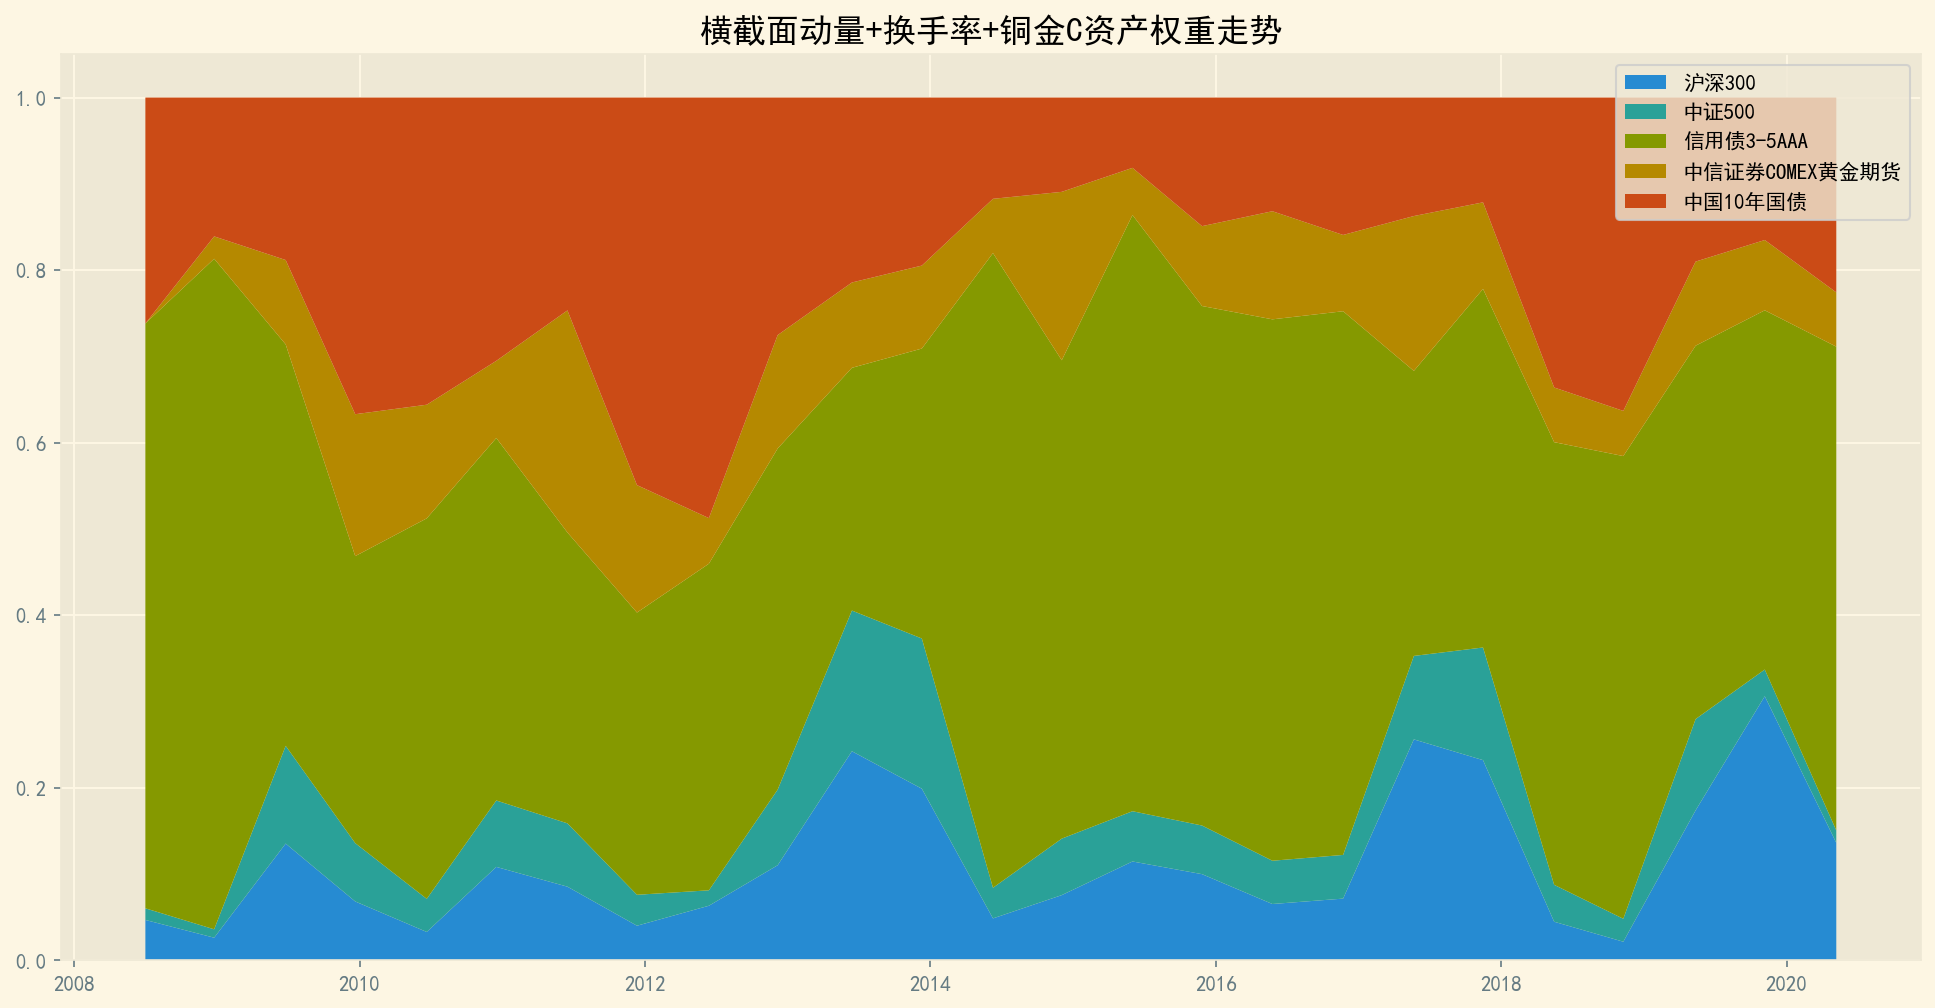

In [121]:
StatisticFunc.WeightPlot(tradeDF_5, weightDF_5, '横截面动量+换手率+铜金C')

### 回测表现汇总

In [122]:
# 表现汇总
years = np.unique(tradeDF_5.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_5 = pd.DataFrame(index=years)

SummaryDF_5["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_5['投资组合净值']) )
SummaryDF_5["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_5['投资组合净值'])).values
SummaryDF_5["无基准夏普比率"] = SummaryDF_5['年收益率'] / SummaryDF_5['年波动率']
SummaryDF_5["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_5['最大回撤'])).values

SummaryDF_5

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.320807,0.134307,2.38861,-0.044437
2009,0.0983148,0.109981,0.893925,-0.063894
2010,0.0615764,0.064464,0.955214,-0.080069
2011,0.0641002,0.083089,0.771467,-0.099277
2012,0.0661975,0.044836,1.47644,-0.051092
2013,-0.0653506,0.089954,-0.726488,-0.118471
2014,0.218924,0.057181,3.82859,-0.125878
2015,0.247551,0.065185,3.79768,-0.047716
2016,0.00029931,0.049926,0.00599502,-0.090223
2017,0.00310533,0.042574,0.072939,-0.113691


### 收益率贡献度

In [123]:
annualContrb_5 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_5, weightDF=weightDF_5, assetDF=leverCumReturns)

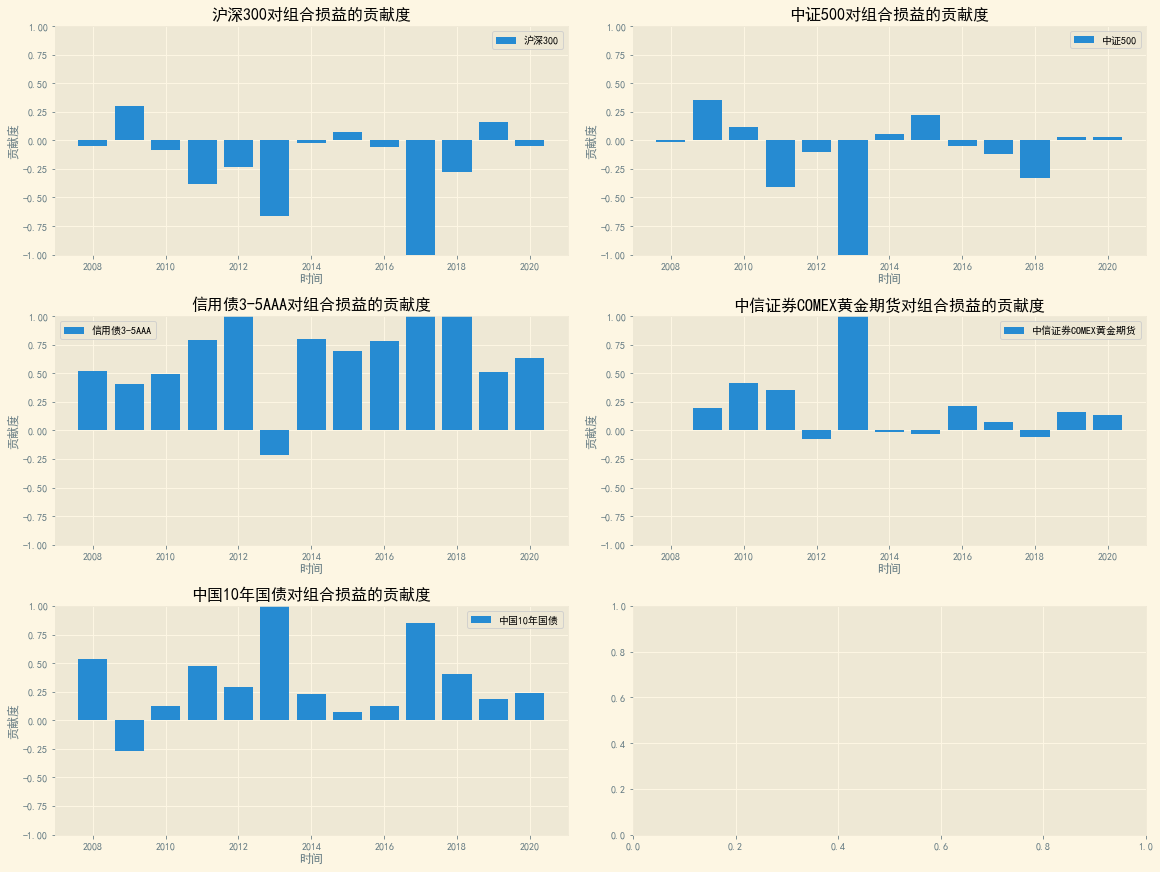

In [124]:
StatisticFunc.BarPlot(annualContrb_5, '横截面动量+换手率+铜金C')

### 投资组合净值曲线

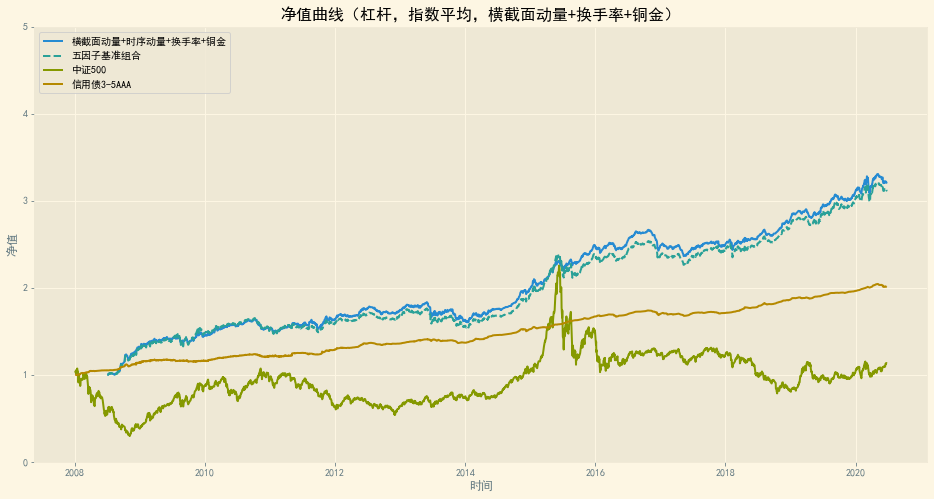

In [125]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金）C.png')